In [1]:
#pip install gensim matplotlib wordcloud spacy pyLDAvis

In [2]:
#python3 -m spacy download en

A document is a control statement. The corpus of these documents includes all controls across all SSPS (AC-1 from SSP3, AC-2 from SSP1). The goal is to find the topics(components) from this wider corpus. We can imagine like controls like all the AC-1 will form a component and that AC-2 might actually be a component with AU-3(not sure if actually just for example)

In [3]:
%matplotlib inline

import pprint
import os
import spacy
import pyLDAvis
import pyLDAvis.gensim  

In [4]:
def remove_extra(doctext):
    """
    Remove extra markdown characters that are not to be used in the analysis
    """
    
    doc = doctext.replace('# Reusable Component Library System Security Plan', "").replace('```text', "").replace('```', '').replace("'", "").replace('*', "")
    return doc

In [5]:
def read_markdown(filename):
    """
    Read in a file as one string with markdown characters removed
    """
    
    file_string = """{}""".format(open(f'{root}/{filename}', encoding="utf8").read())
    # Remove extra markdown characters
    clean_file_string = remove_extra(file_string)
    return clean_file_string


In [6]:
def remove_stopwords(texts):
    # Create a set of frequent words that add no value to our analysis
    # at the moment this is optional despite its use here
    stop_words = set("for a of the and to in as are or and/or * # ## ### #### ##### – - 1. 2. 3. 4. 1 2 3 4 a. b. c. d. a b c d".split(' '))
    return [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

   # return [[word for word in document.lower().split() if word not in stoplist] for document in texts]


def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [7]:
import os
# Folder with controls
root = f"{os.getcwd()}/docs/controls"

# control corpus
text_corpus = []
for filename in os.listdir(root):
    # Assign variable names dynamically
    name = ''.join(filename).replace(".", "_")
    data = read_markdown(filename)
    text_corpus.append(data)

In [8]:
def clean(text):
    return str(''.join([i if ord(i) < 128 else ' ' for i in text]))

In [107]:
import gensim
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(text_corpus))
print(data_words)


[['nist', 'sp', 'revision', 'ac', 'access', 'control', 'ac', 'access', 'control', 'policy', 'and', 'procedures', 'the', 'organization', 'develops', 'documents', 'and', 'disseminates', 'to', 'assignment', 'organization', 'defined', 'personnel', 'or', 'roles', 'an', 'access', 'control', 'policy', 'that', 'addresses', 'purpose', 'scope', 'roles', 'management', 'commitment', 'coordination', 'among', 'organizational', 'entities', 'and', 'compliance', 'and', 'procedures', 'to', 'facilitate', 'the', 'implementation', 'of', 'the', 'access', 'control', 'policy', 'and', 'associated', 'access', 'controls', 'and', 'reviews', 'and', 'updates', 'the', 'current', 'access', 'control', 'policy', 'assignment', 'organization', 'defined', 'frequency', 'and', 'access', 'control', 'procedures', 'assignment', 'organization', 'defined', 'frequency', 'status', 'complete', 'civicactions', 'civicactions', 'has', 'developed', 'documented', 'and', 'disseminated', 'to', 'personnel', 'an', 'access', 'control', 'poli

# Build the bigram and trigram models


In [11]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [12]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)#text_corpus

#Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# Count word frequencies
from collections import defaultdict
frequency = defaultdict(int)
for text in data_lemmatized:
    for token in text:# doc_to_words(text)
        token = "".join(token)
        frequency[token] += 1

# Only keep words that appear more than once
processed_corpus = [[token for token in text if frequency[token] > 1] for text in data_lemmatized]
#pprint.pprint(processed_corpus)

## Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).

In [13]:
from gensim import corpora
# Create Dictionary

dictionary = corpora.Dictionary(data_lemmatized)#processed_corpus
#pprint.pprint(dictionary.token2id)

# example of term document frequency

In [14]:
new_doc = "Access 800-53"
new_vec = dictionary.doc2bow(new_doc.lower().split())
#print(new_vec)

## convert our entire processed corpus to a list of vectors (word_id, word_frequency):

In [15]:
# Term Document Frequency
bow_corpus = [dictionary.doc2bow(text) for text in data_lemmatized]
#pprint.pprint(bow_corpus)

In [16]:
# Human readable format of corpus (term-frequency)
human_readable_corpus = [[(dictionary[id], freq) for id, freq in cp] for cp in bow_corpus[:1]]
#human_readable_corpus

# TfidfModel

In [17]:
from gensim import models

# train the model
tfidf = models.TfidfModel(bow_corpus)

# transform the "system minors" string
words = "access security".lower().split()
#print(tfidf[dictionary.doc2bow(words)])

In [18]:
from gensim import similarities

index = similarities.SparseMatrixSimilarity(tfidf[bow_corpus], num_features=len(dictionary.token2id)) # len(dictionary.token2id) is the number of features

and to query the similarity of our query document ``query_document`` against every document in the corpus:



In [19]:
#query_document = 'access security'.split()
query_document = data_lemmatized[0]# AC.md after all pre-processing
query_bow = dictionary.doc2bow(query_document)
sims = index[tfidf[query_bow]]
print(list(enumerate(sims)))

[(0, 0.99999744), (1, 0.1387942), (2, 0.04209767), (3, 0.08495008), (4, 0.16163144), (5, 0.07594763), (6, 0.15709268), (7, 0.08019437), (8, 0.03521914), (9, 0.03689903), (10, 0.27233127), (11, 0.06157983), (12, 0.09341411), (13, 0.09557665), (14, 0.047743537), (15, 0.047065895), (16, 0.13603939), (17, 0.1513767), (18, 0.060967885), (19, 0.13937286), (20, 0.12508523), (21, 0.030448807), (22, 0.122066975), (23, 0.056770608), (24, 0.06647543)]


How to read this output?
Document 0 has a similarity score of 0.99999744=99%(Since its just the post-processed copy of AC.md), Document 1 has a similarity score of 14%, and Document 2 has a similarity score of 4%, etc.
We can make this slightly more readable by sorting:



In [20]:
# Sorted by similiarity score
for document_number, score in sorted(enumerate(sims), key=lambda x: x[1], reverse=True):
    print(f"Document {document_number}", f"has a similiarity score of {score:.2f}")

Document 0 has a similiarity score of 1.00
Document 10 has a similiarity score of 0.27
Document 4 has a similiarity score of 0.16
Document 6 has a similiarity score of 0.16
Document 17 has a similiarity score of 0.15
Document 19 has a similiarity score of 0.14
Document 1 has a similiarity score of 0.14
Document 16 has a similiarity score of 0.14
Document 20 has a similiarity score of 0.13
Document 22 has a similiarity score of 0.12
Document 13 has a similiarity score of 0.10
Document 12 has a similiarity score of 0.09
Document 3 has a similiarity score of 0.08
Document 7 has a similiarity score of 0.08
Document 5 has a similiarity score of 0.08
Document 24 has a similiarity score of 0.07
Document 11 has a similiarity score of 0.06
Document 18 has a similiarity score of 0.06
Document 23 has a similiarity score of 0.06
Document 14 has a similiarity score of 0.05
Document 15 has a similiarity score of 0.05
Document 2 has a similiarity score of 0.04
Document 9 has a similiarity score of 0.

# Word clouds

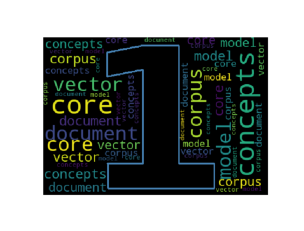

In [21]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('img/run_core_concepts.png')
imgplot = plt.imshow(img)
_ = plt.axis('off')

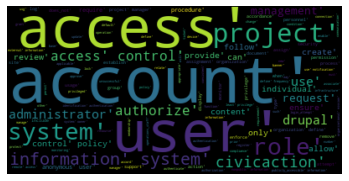

In [22]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Start with one document:
text = str(data_lemmatized[0])

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

wordcloud.to_file("img/AC_wordcloud_example.png")

# Latent Semantic Indexing:

In [23]:
from gensim import models
lsi = models.LsiModel(bow_corpus, id2word=dictionary, num_topics=2)

In [24]:
doc = text_corpus[0]# Just an example the first model will be a 100% max
vec_bow = dictionary.doc2bow(doc.lower().split())
vec_lsi = lsi[vec_bow]  # convert the query to LSI space
print(vec_lsi)

[(0, 124.08928647138211), (1, -47.12492408471892)]


In [25]:
from gensim import similarities
index = similarities.MatrixSimilarity(lsi[bow_corpus])  # transform corpus to LSI space and index it

# Similiarity Query

In [26]:
sims = index[vec_lsi]  # perform a similarity query against the corpus
print(list(enumerate(sims)))  # print (document_number, document_similarity) 2-tuples

[(0, 0.99999267), (1, 0.9998268), (2, 0.83588135), (3, 0.6960639), (4, 0.90550363), (5, 0.5883225), (6, 0.8078434), (7, 0.7636117), (8, 0.9584336), (9, 0.92855406), (10, 0.93041986), (11, 0.99429667), (12, 0.6596291), (13, 0.82284194), (14, 0.775597), (15, 0.8355307), (16, 0.7207158), (17, 0.8202195), (18, 0.68748903), (19, 0.7743372), (20, 0.84945226), (21, 0.7888795), (22, 0.72959274), (23, 0.97726136), (24, 0.98280406)]


# sort

In [27]:
sims = sorted(enumerate(sims), key=lambda item: item[-1])
for doc_position, doc_score in sims:
    print(doc_score, data_lemmatized[doc_position][0])# just printing the first word in a document

0.5883225 revision
0.6596291 revision
0.68748903 revision
0.6960639 revision
0.7207158 plan
0.72959274 revision
0.7636117 revision
0.7743372 revision
0.775597 revision
0.7888795 revision
0.8078434 revision
0.8202195 revision
0.82284194 revision
0.8355307 policy
0.83588135 nist_sp
0.84945226 revision
0.90550363 revision
0.92855406 nist_sp
0.93041986 revision
0.9584336 revision
0.97726136 nist_sp
0.98280406 nist_sp
0.99429667 revision
0.9998268 nist_sp
0.99999267 revision


# Many to many

For a many to many running of the above just create a model and use a list of like-documents(SSPs or control text model) in a list and chugging through doing similarity queries, etc. Again the model is an algorithm for the give type of documents so if the documents are SSPs then the model should be used to make NLP predictions for whole SSPs. Likewise, for a model built from controls only predicts controls.  


# LDA

LDA’s approach to topic modeling is it considers each document as a collection of topics in a certain proportion. And each topic as a collection of keywords, again, in a certain proportion.

Once you provide the algorithm with the number of topics, all it does it to rearrange the topics distribution within the documents and keywords distribution within the topics to obtain a good composition of topic-keywords distribution.

When I say topic, what is it actually and how it is represented?

A topic is nothing but a collection of dominant keywords that are typical representatives. Just by looking at the keywords, you can identify what the topic is all about.

In [67]:
from gensim.models import LdaModel

# Build LDA model
ldamodel = gensim.models.ldamodel.LdaModel(corpus=bow_corpus,
                                           id2word=dictionary,
                                           num_topics=25, 
                                           random_state=100,
                                           update_every=1,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


# View the topics in the LDA model


In [68]:
# Print the Keyword in the 10 topics
pprint.pprint(ldamodel.print_topics())# .show_topics()
#doc_lda = ldamodel[bow_corpus]

[(3,
  '0.001*"system" + 0.001*"civicaction" + 0.001*"security" + 0.001*"user" + '
  '0.001*"organization" + 0.001*"information" + 0.001*"project" + '
  '0.001*"password" + 0.001*"use" + 0.001*"plan"'),
 (23,
  '0.001*"control" + 0.001*"system" + 0.001*"organization" + '
  '0.001*"civicaction" + 0.001*"information" + 0.001*"security" + '
  '0.001*"access" + 0.001*"policy" + 0.001*"define" + 0.001*"user"'),
 (1,
  '0.002*"system" + 0.002*"civicaction" + 0.001*"project" + 0.001*"user" + '
  '0.001*"information" + 0.001*"security" + 0.001*"access" + '
  '0.001*"organization" + 0.001*"control" + 0.001*"account"'),
 (6,
  '0.002*"system" + 0.001*"project" + 0.001*"information" + '
  '0.001*"civicaction" + 0.001*"user" + 0.001*"access" + 0.001*"security" + '
  '0.001*"use" + 0.001*"account" + 0.001*"control"'),
 (21,
  '0.001*"civicaction" + 0.001*"organization" + 0.001*"security" + '
  '0.001*"system" + 0.001*"information" + 0.001*"log" + 0.001*"project" + '
  '0.001*"user" + 0.001*"audit" 

# How to interpret?
Topic 0 is a represented as _'0.003*"access" + 0.002*"system" + 0.002*"account" + 0.002*"user" + '
  '0.002*"information" + 0.002*"role" + 0.002*"project" + 0.002*"control" + '
  '0.002*"privacy" + 0.002*"use"'
  
It means that the top 10 keywords that contribute to this topic are: ‘access’, ‘system’, ‘account’.. and so on and the weight of ‘access’ on topic 0 is 0.003.
The weights reflect how important a keyword is to that topic. Given our prior knowledge of there being 25 control families used for this analysis I used 25 as the number of topics.

In [71]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, bow_corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
24    -0.135976 -0.030929       1        1  16.514071
9     -0.172030 -0.036832       2        1  15.093284
0     -0.128631 -0.091560       3        1  14.115892
22    -0.236215 -0.055452       4        1  12.004970
14    -0.201043 -0.059095       5        1  11.521838
2     -0.183041 -0.008979       6        1  11.472032
12    -0.210419 -0.055830       7        1   9.607218
19    -0.137641  0.229753       8        1   4.135442
20    -0.072938  0.228453       9        1   2.290718
11     0.056720 -0.083594      10        1   1.391390
13    -0.036768 -0.045820      11        1   1.236542
15     0.041867  0.155490      12        1   0.521750
18     0.071488 -0.003337      13        1   0.062457
4      0.099848 -0.010464      14        1   0.002832
8      0.094408 -0.011026      15        1   0.002790
7      0.092104 -0.013584      16        1   0.002775
17     0.104842 -0.013324      17        1   0.002744
5      0.088123 -0.019014      18        1   0.002739
10     0.106966 -0.013036      19        1   0.002718
16     0.126730 -0.009500      20        1   0.002703
21     0.124503 -0.008532      21        1   0.002683
6      0.122177 -0.008664      22        1   0.002659
1      0.119109 -0.012766      23        1   0.002637
23     0.129349 -0.011530      24        1   0.002600
3      0.136468 -0.010828      25        1   0.002517, topic_info=            Term        Freq       Total Category  logprob  loglift
437       system  651.000000  651.000000  Default  30.0000  30.0000
216  information  455.000000  455.000000  Default  29.0000  29.0000
403     security  443.000000  443.000000  Default  28.0000  28.0000
464         user  266.000000  266.000000  Default  27.0000  27.0000
75   civicaction  529.000000  529.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
2         access    0.000312  254.973633  Topic25  -7.3931  -3.0251
382  requirement    0.000308   90.000404  Topic25  -7.4051  -1.9958
119       define    0.000311  247.445572  Topic25  -7.3959  -2.9980
261   management    0.000307   97.625763  Topic25  -7.4073  -2.0793
342    procedure    0.000308  129.742538  Topic25  -7.4047  -2.3611

[1633 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1444      4  0.844450     abide
2         1  0.109815    access
2         2  0.227474    access
2         3  0.086283    access
2         4  0.039220    access
...     ...       ...       ...
481       6  0.098939      will
481       7  0.415544      will
481       9  0.039576      will
483       6  0.902695  wireless
1375      4  0.888917  workflow

[1783 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[25, 10, 1, 23, 15, 3, 13, 20, 21, 12, 14, 16, 19, 5, 9, 8, 18, 6, 11, 17, 22, 7, 2, 24, 4])

As you might notice there is a lot of overlap in one quadrant which is an indiciator of a bad topic model. Need to find the optimium number of topics

In [712]:

# mallet_path = r"D:/'Geek Squad Backup'/Users/Backup_David/Desktop/'Admin Life'/Job-Career/GovReady/CMS/SSP_analysis_draft/mallet-2.0.8" # update this path
# os.environ.update({'MALLET_HOME':mallet_path})

# print(os.environ)
# path = r'D:\\Geek Squad Backup\\Users\\Backup_David\\Desktop\\Admin Life\\Job-Career\\GovReady\\CMS\\SSP_analysis_draft\\mallet-2.0.8\\bin\\mallet'

environ({'ALLUSERSPROFILE': 'C:\\ProgramData', 'APPDATA': 'C:\\Users\\flyff\\AppData\\Roaming', 'COMMONPROGRAMFILES': 'C:\\Program Files\\Common Files', 'COMMONPROGRAMFILES(X86)': 'C:\\Program Files (x86)\\Common Files', 'COMMONPROGRAMW6432': 'C:\\Program Files\\Common Files', 'COMPUTERNAME': 'MSI', 'COMSPEC': 'C:\\WINDOWS\\system32\\cmd.exe', 'CONFIGSETROOT': 'C:\\WINDOWS\\ConfigSetRoot', 'DRIVERDATA': 'C:\\Windows\\System32\\Drivers\\DriverData', 'FPS_BROWSER_APP_PROFILE_STRING': 'Internet Explorer', 'FPS_BROWSER_USER_PROFILE_STRING': 'Default', 'HOMEDRIVE': 'C:', 'HOMEPATH': '\\Users\\flyff', 'LOCALAPPDATA': 'C:\\Users\\flyff\\AppData\\Local', 'LOGONSERVER': '\\\\MSI', 'NUMBER_OF_PROCESSORS': '12', 'ONEDRIVE': 'C:\\Users\\flyff\\OneDrive', 'OS': 'Windows_NT', 'PATH': 'C:\\Program Files (x86)\\NVIDIA Corporation\\PhysX\\Common;C:\\Program Files\\GTK3-Runtime Win64\\bin\\;C:\\Program Files (x86)\\Razer\\ChromaBroadcast\\bin;C:\\Program Files\\Razer\\ChromaBroadcast\\bin;C:\\Program Fi

# LDA model topic optimization

In [61]:
from gensim.models import CoherenceModel

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        model = gensim.models.ldamodel.LdaModel(corpus=bow_corpus, id2word=dictionary, num_topics=num_topics, random_state=100, passes=10, alpha='auto', per_word_topics=True)

        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [62]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=bow_corpus, texts=data_lemmatized, start=2, limit=10, step=1)

2
3
4
5
6
7
8
9


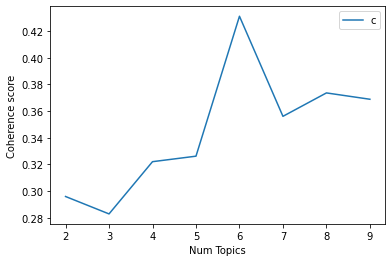

In [63]:
# Show graph
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

As we can see above the optimium number of topics is 6 given it has the highest coherence score for our given corpus and dictionary.

In [72]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2959
Num Topics = 3  has Coherence Value of 0.2828
Num Topics = 4  has Coherence Value of 0.322
Num Topics = 5  has Coherence Value of 0.3262
Num Topics = 6  has Coherence Value of 0.4311
Num Topics = 7  has Coherence Value of 0.3561
Num Topics = 8  has Coherence Value of 0.3736
Num Topics = 9  has Coherence Value of 0.3689


In [65]:
# Optimum topics LDA model
ldamodel2 = gensim.models.ldamodel.LdaModel(corpus=bow_corpus,
                                           id2word=dictionary,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis2 = pyLDAvis.gensim.prepare(ldamodel2, bow_corpus, dictionary)
vis2

In [ ]:
# Select the model and print the topics
optimal_model = model_list[4]
model_topics = optimal_model.show_topics(formatted=False)
pprint.pprint(optimal_model.print_topics(num_words=10))

# Finding the dominant topic in each sentence

In [ ]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
       # row = sorted(enumerate(row), key=lambda item: item[-1])
        row = sorted(row)
        print(row)

In [ ]:
import pandas as pd

df_topic_sents_keywords = format_topics_sentences(optimal_model, bow_corpus, data_lemmatized)



# Format
#df_dominant_topic = df_topic_sents_keywords.reset_index()
#df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show

In [ ]:
new_topics = optimal_model[bow_corpus]

for i, row in enumerate(new_topics):

      print(i)

In [66]:
new_topics = optimal_model[bow_corpus]

for i, row in enumerate(new_topics):

      print(i)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.070239  0.034043       1        1  33.306564
0      0.090943 -0.009949       2        1  29.399744
5      0.118379 -0.038645       3        1  26.014503
4     -0.034634  0.128713       4        1   7.563400
1     -0.090220 -0.156862       5        1   2.974206
3     -0.154707  0.042700       6        1   0.741584, topic_info=               Term        Freq       Total Category  logprob  loglift
75      civicaction  511.000000  511.000000  Default  30.0000  30.0000
328            plan  113.000000  113.000000  Default  29.0000  29.0000
216     information  443.000000  443.000000  Default  28.0000  28.0000
338         privacy   72.000000   72.000000  Default  27.0000  27.0000
762        incident   58.000000   58.000000  Default  26.0000  26.0000
..              ...         ...         ...      ...      ...      ...
2            access    0.397697  248.755676   Topic6  -5.9271  -1.5344
381         require    0.394413  119.710129   Topic6  -5.9354  -0.8113
49   authentication    0.392356   59.175587   Topic6  -5.9406  -0.1120
478            when    0.391713   73.834984   Topic6  -5.9423  -0.3349
274         monitor    0.391603   50.035164   Topic6  -5.9425   0.0539

[411 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
2         1  0.659281       access
2         2  0.188940       access
2         3  0.084420       access
2         4  0.064320       access
1318      5  0.806091  accordingly
...     ...       ...          ...
481       1  0.302592         will
481       2  0.040346         will
481       3  0.605183         will
481       4  0.040346         will
1375      5  0.674926     workflow

[742 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 6, 5, 2, 4])

In [76]:
# Select the model and print the topics
optimal_model = model_list[4]
model_topics = optimal_model.show_topics(formatted=False)
pprint.pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.031*"system" + 0.021*"civicaction" + 0.019*"information" + '
  '0.018*"security" + 0.018*"control" + 0.017*"organization" + 0.015*"log" + '
  '0.014*"define" + 0.011*"audit" + 0.010*"include"'),
 (1,
  '0.053*"incident" + 0.031*"plan" + 0.029*"civicaction" + 0.023*"team" + '
  '0.013*"capability" + 0.012*"incident_response" + 0.011*"event" + '
  '0.011*"organization" + 0.010*"handle" + 0.010*"activity"'),
 (2,
  '0.032*"system" + 0.028*"user" + 0.024*"access" + 0.021*"information" + '
  '0.021*"civicaction" + 0.019*"project" + 0.019*"account" + 0.015*"password" '
  '+ 0.013*"organization" + 0.011*"use"'),
 (3,
  '0.016*"share" + 0.016*"pii" + 0.014*"information" + 0.014*"purpose" + '
  '0.011*"privacy" + 0.011*"party" + 0.011*"third" + 0.009*"use" + '
  '0.007*"identify" + 0.007*"notice"'),
 (4,
  '0.043*"privacy" + 0.024*"information" + 0.023*"organization" + '
  '0.021*"control" + 0.020*"maintenance" + 0.019*"pii" + 0.018*"collect" + '
  '0.016*"project" + 0.015*"system" + 

# Finding the dominant topic in each sentence

In [105]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
       # row = sorted(enumerate(row), key=lambda item: item[-1])
        row = sorted(row)
        print(row)

In [106]:
import pandas as pd

df_topic_sents_keywords = format_topics_sentences(optimal_model, bow_corpus, data_lemmatized)



# Format
#df_dominant_topic = df_topic_sents_keywords.reset_index()
#df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show

TypeError: '<' not supported between instances of 'tuple' and 'int'

In [90]:
new_topics = optimal_model[bow_corpus]

for i, row in enumerate(new_topics):

      print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
